# 🎯 K-Nearest Neighbors Regression - Instance-Based Learning

**Module 01: Regression Algorithms (Supervised Learning)**

---

## 🎯 Learning Objectives

By the end of this notebook, you will understand:

1. **KNN Foundation** - How lazy learning differs from model-based learning
2. **Distance Metrics** - Euclidean, Manhattan, Minkowski, and when to use each
3. **The K Parameter** - Finding optimal number of neighbors
4. **Weighting Schemes** - Uniform vs distance-weighted voting
5. **Curse of Dimensionality** - Why KNN struggles with many features
6. **Production Considerations** - Memory usage, prediction speed, scaling

---

## 📚 Section 1: Theoretical Foundation

### What is K-Nearest Neighbors (KNN) Regression?

**Traditional Models (Linear Regression, SVR):**
```
Training Phase: Learn parameters (weights, support vectors)
Prediction Phase: Use learned parameters → Fast
```

**KNN - Lazy Learning:**
```
Training Phase: Just store all training data → Instant
Prediction Phase: Search for K nearest neighbors → Slower
```

---

### 🔍 How KNN Regression Works

**Step-by-Step Prediction Process:**

1. **Store Training Data** - No training phase, just memorize all points
2. **For New Point** - Calculate distance to ALL training points
3. **Find K Nearest** - Select K closest neighbors
4. **Average Their Values** - Prediction = mean of K neighbor targets

**Visual Example (K=3):**
```
     y
     |
   8 |     • (neighbor: 8.2)
     |
   6 |       ? (new point)
     |     • (neighbor: 6.1)
   4 |   • (neighbor: 4.5)
     |
   2 |
     |_________________ x

Prediction = (8.2 + 6.1 + 4.5) / 3 = 6.27
```

---

### 📏 Distance Metrics

#### 1. **Euclidean Distance** (Most Common) - Straight line
```
d = √[(x₁-x₂)² + (y₁-y₂)²]
```
- Standard geometric distance
- Sensitive to scale → **Feature scaling required**
- Works well for continuous features

#### 2. **Manhattan Distance** (City Block) - Grid-like path
```
d = |x₁-x₂| + |y₁-y₂|
```
- Sum of absolute differences
- Less sensitive to outliers than Euclidean
- Good for high-dimensional data

#### 3. **Minkowski Distance** (Generalization)
```
d = (Σ|xᵢ-yᵢ|ᵖ)^(1/p)
```
- p=1 → Manhattan
- p=2 → Euclidean
- p=∞ → Chebyshev (max difference)

#### 4. **Chebyshev Distance** - Maximum difference
```
d = max(|x₁-x₂|, |y₁-y₂|)
```
- Only largest difference matters
- Good when one feature dominates

---

### ⚖️ Weighting Schemes

**Uniform Weights:**
- All K neighbors contribute equally
- Simple average: `prediction = mean(neighbors)`

**Distance Weights:**
- Closer neighbors have more influence
- `weight = 1 / distance`
- Better for varying densities

**When to use which:**
- **Uniform**: Data is uniformly distributed
- **Distance**: Neighbors at varying distances

---

### 🎛️ The K Parameter - Most Critical Hyperparameter

| **K Value** | **Effect** | **Bias** | **Variance** |
|------------|-----------|---------|-------------|
| **K = 1** | Memorizes training data | Low | High (Overfitting) |
| **K = 3-5** | Balanced, good starting point | Medium | Medium |
| **K = 10-20** | Smoother predictions | Medium | Medium |
| **K = N** | Predicts mean of all data | High | Low (Underfitting) |

**Visual Impact:**
```
K=1:  Jagged, overfits noise
K=5:  Smooth, captures patterns
K=50: Very smooth, misses details
```

---

### 📊 Advantages vs Disadvantages

| **Advantages ✅** | **Disadvantages ❌** |
|------------------|---------------------|
| No training phase (instant) | Slow predictions (O(n)) |
| Simple, intuitive | High memory usage (stores all data) |
| No assumptions about data | Feature scaling required |
| Naturally handles multi-output | Curse of dimensionality |
| Works with any distance metric | Sensitive to irrelevant features |
| Non-parametric (flexible) | Imbalanced data issues |

---

### 🚨 The Curse of Dimensionality

**Problem:** As features increase, all points become equally distant!

```
2D:   Clear neighbors     10D: All points ~same distance
  •   •                      • • • • • •
    X                          • X • •
  •   •                      • • • • • •
```

**Impact on KNN:**
- High dimensions → Distances lose meaning
- Need exponentially more data
- Performance degrades rapidly beyond ~10-15 features

**Solutions:**
- Feature selection / dimensionality reduction (PCA)
- Use distance-weighted voting
- Try different distance metrics

---

### 📈 When to Use KNN Regression?

| **Use KNN When** | **Avoid KNN When** |
|------------------|-------------------|
| Small to medium datasets | Large datasets (>10,000 samples) |
| Low to medium dimensions (<20 features) | High dimensions (>50 features) |
| Non-linear relationships | Real-time predictions needed |
| Data has local patterns | Data is uniformly distributed |
| No assumptions about distribution | Memory is limited |
| Need simple, interpretable model | Need fast predictions |

## 🔧 Section 2: Setup & Dataset Loading

In [4]:
# Import Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing, make_regression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")
print("💡 KNN is memory-intensive - we'll use a subset for demonstration")

✅ Libraries imported successfully!
💡 KNN is memory-intensive - we'll use a subset for demonstration


In [6]:
# Load California Housing Dataset
housing = fetch_california_housing(as_frame=True)
df = housing.frame

# Use subset for demonstration (KNN stores all training data)
np.random.seed(42)
sample_size = 3000
sample_indices = np.random.choice(df.index, size=sample_size, replace=False)
df_sample = df.loc[sample_indices].reset_index(drop=True)

print("📊 California Housing Dataset Loaded (Sampled)")
print(f"Original shape: {df.shape}")
print(f"Sampled shape: {df_sample.shape}")
print(f"\nFeatures: {list(housing.feature_names)}")
print(f"Target: Median House Value")
print("\n" + "="*70)
print(df_sample.head())

📊 California Housing Dataset Loaded (Sampled)
Original shape: (20640, 9)
Sampled shape: (3000, 9)

Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target: Median House Value

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  1.6812      25.0  4.192201   1.022284      1392.0  3.877437     36.06   
1  2.5313      30.0  5.039384   1.193493      1565.0  2.679795     35.14   
2  3.4801      52.0  3.977155   1.185877      1310.0  1.360332     37.80   
3  5.7376      17.0  6.163636   1.020202      1705.0  3.444444     34.28   
4  3.7250      34.0  5.492991   1.028037      1063.0  2.483645     36.62   

   Longitude  MedHouseVal  
0    -119.01      0.47700  
1    -119.46      0.45800  
2    -122.44      5.00001  
3    -118.72      2.18600  
4    -121.93      2.78000  


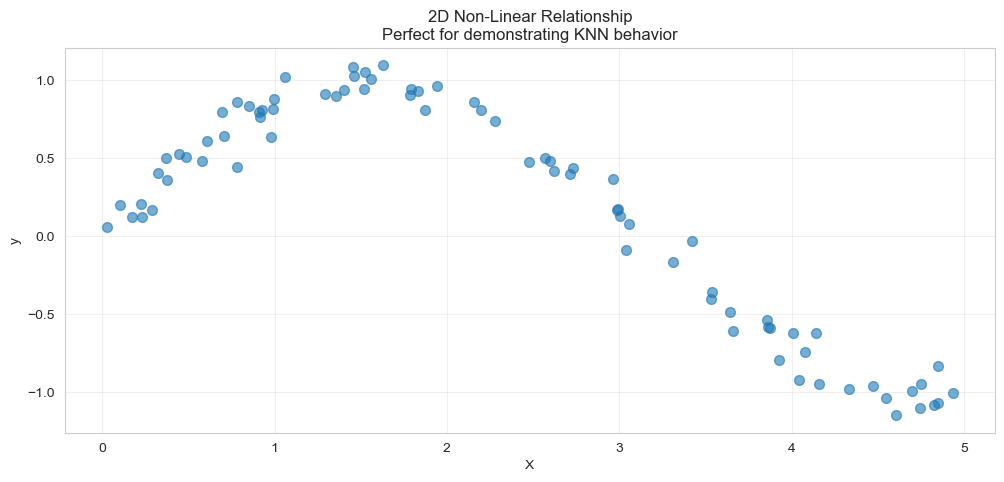


📌 This simple dataset will help visualize how K affects predictions


In [8]:
# Create simple 2D dataset for visualization
np.random.seed(42)
X_2d = np.sort(5 * np.random.rand(80, 1), axis=0)
y_2d = np.sin(X_2d).ravel() + np.random.normal(0, 0.1, X_2d.shape[0])

plt.figure(figsize=(12, 5))
plt.scatter(X_2d, y_2d, alpha=0.6, s=50)
plt.xlabel('X')
plt.ylabel('y')
plt.title('2D Non-Linear Relationship\nPerfect for demonstrating KNN behavior')
plt.grid(True, alpha=0.3)
plt.show()

print("\n📌 This simple dataset will help visualize how K affects predictions")

In [10]:
# Split main dataset
X = df_sample.drop('MedHouseVal', axis=1)
y = df_sample['MedHouseVal']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\n✂️ Data Split:")
print(f"Training: {X_train.shape[0]} samples")
print(f"Testing: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")


✂️ Data Split:
Training: 2400 samples
Testing: 600 samples
Features: 8


In [12]:
# Feature Scaling (CRITICAL for KNN!)
print("\n⚖️ Feature Scaling Analysis:")
print("="*70)
print("KNN uses distances, so feature scales MUST be comparable!")
print("\nBefore Scaling:")
print(X_train.describe().loc[['mean', 'std']])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Features Standardized (mean=0, std=1)")
print("After Scaling:")
print(pd.DataFrame(X_train_scaled, columns=X_train.columns).describe().loc[['mean', 'std']])


⚖️ Feature Scaling Analysis:
KNN uses distances, so feature scales MUST be comparable!

Before Scaling:
        MedInc   HouseAge  AveRooms  AveBedrms   Population  AveOccup  \
mean  3.841656  28.910000  5.391070   1.094171  1408.027917  2.981493   
std   1.904116  12.315848  2.118683   0.375885  1075.711489  2.203386   

       Latitude   Longitude  
mean  35.589892 -119.525408  
std    2.137415    1.984447  

✅ Features Standardized (mean=0, std=1)
After Scaling:
            MedInc      HouseAge      AveRooms     AveBedrms    Population  \
mean -1.665335e-16 -8.881784e-18 -6.069219e-17  5.432691e-16 -1.480297e-17   
std   1.000208e+00  1.000208e+00  1.000208e+00  1.000208e+00  1.000208e+00   

          AveOccup      Latitude     Longitude  
mean  1.480297e-17  3.398763e-15 -1.037688e-15  
std   1.000208e+00  1.000208e+00  1.000208e+00  


## 🧪 Section 3: KNN with Different K Values

### 3.1 Visualizing K Effect (2D Data)

In [16]:
# Train KNN with different K values on 2D data
X_2d_scaled = StandardScaler().fit_transform(X_2d)
X_plot = np.linspace(X_2d.min(), X_2d.max(), 300).reshape(-1, 1)
X_plot_scaled = StandardScaler().fit_transform(X_plot)

k_values = [1, 3, 10, 30]
predictions = {}

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_2d_scaled, y_2d)
    predictions[k] = knn.predict(X_plot_scaled)

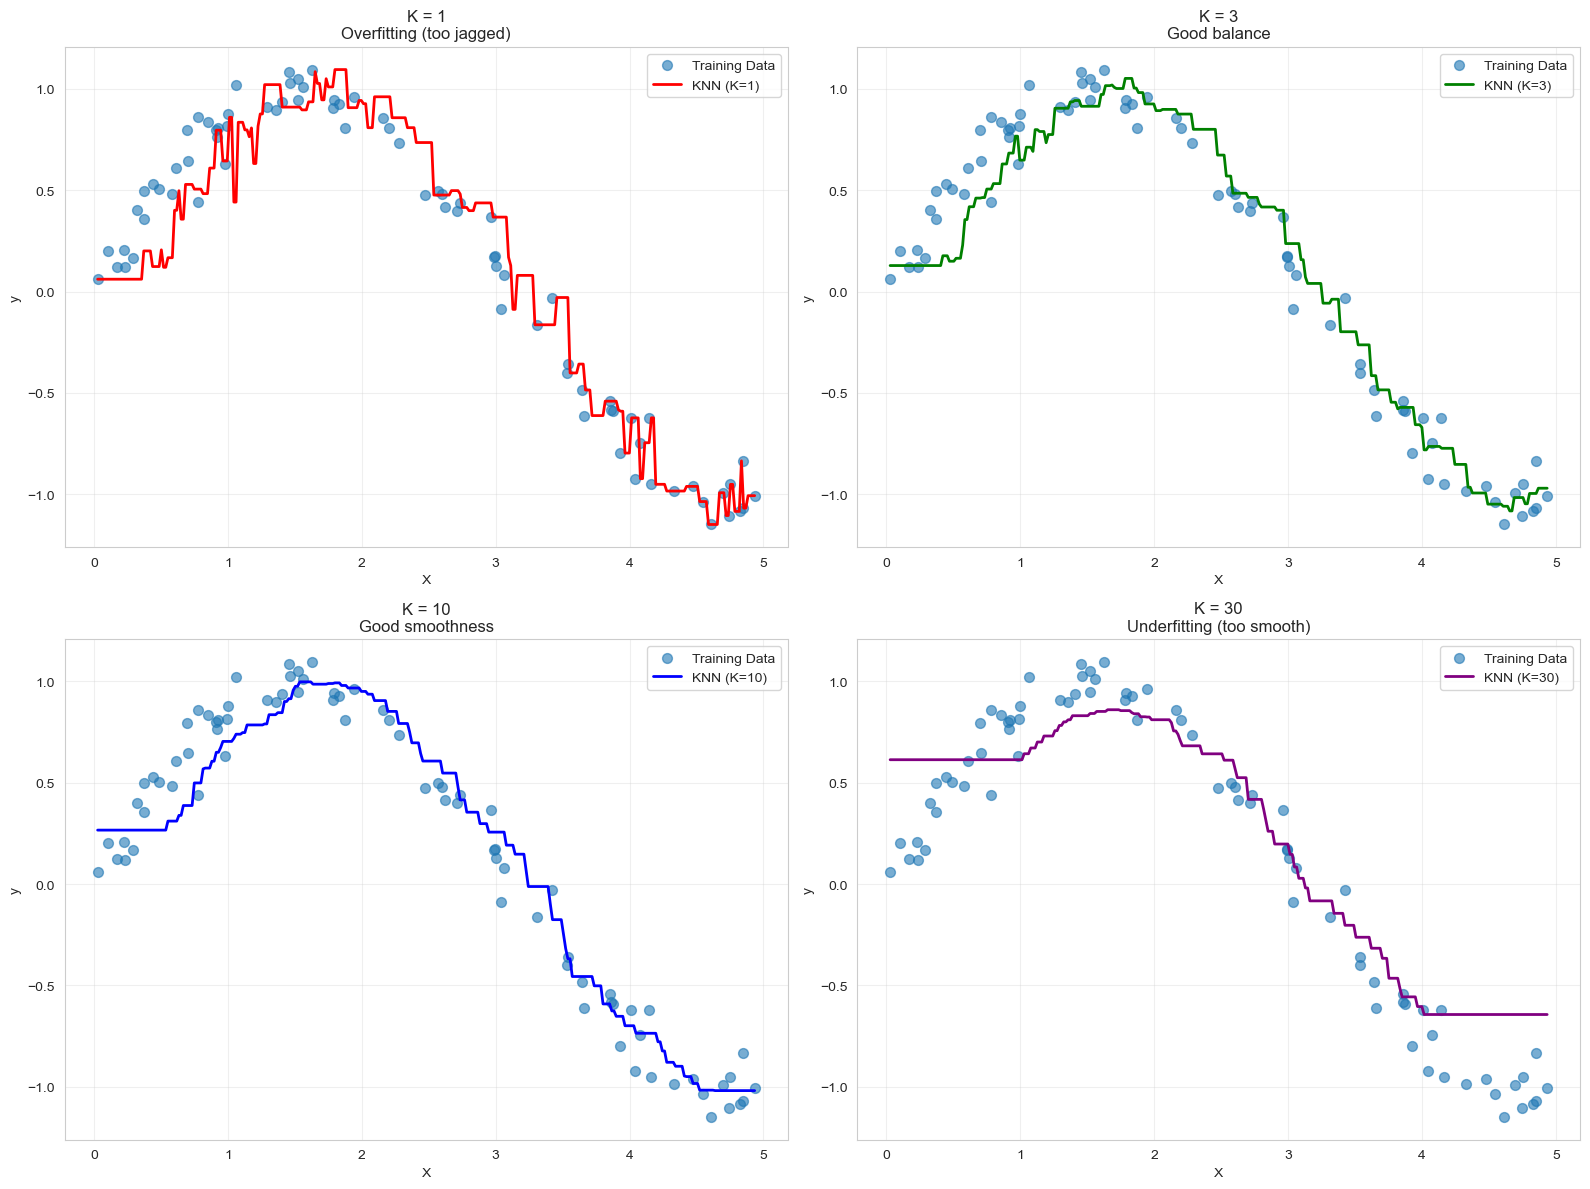


🔍 Key Observations:
  K=1:  Passes through every training point (overfitting)
  K=3:  Smooth but captures pattern (good balance)
  K=10: Very smooth curve (still good)
  K=30: Misses curvature details (underfitting)


In [18]:
# Visualize K effect
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
colors = ['red', 'green', 'blue', 'purple']

for idx, k in enumerate(k_values):
    ax = axes[idx // 2, idx % 2]
    
    # Plot data
    ax.scatter(X_2d, y_2d, alpha=0.6, s=50, label='Training Data')
    
    # Plot predictions
    ax.plot(X_plot, predictions[k], color=colors[idx], linewidth=2, 
            label=f'KNN (K={k})')
    
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.set_title(f'K = {k}\n{"Overfitting (too jagged)" if k==1 else "Good balance" if k==3 else "Good smoothness" if k==10 else "Underfitting (too smooth)"}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔍 Key Observations:")
print("  K=1:  Passes through every training point (overfitting)")
print("  K=3:  Smooth but captures pattern (good balance)")
print("  K=10: Very smooth curve (still good)")
print("  K=30: Misses curvature details (underfitting)")

### 3.2 Testing Different K Values (Real Data)

In [21]:
# Test K values from 1 to 50
k_range = range(1, 51)
train_scores = []
test_scores = []

print("🔍 Testing K values from 1 to 50...")

for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    
    train_pred = knn.predict(X_train_scaled)
    test_pred = knn.predict(X_test_scaled)
    
    train_scores.append(r2_score(y_train, train_pred))
    test_scores.append(r2_score(y_test, test_pred))

🔍 Testing K values from 1 to 50...


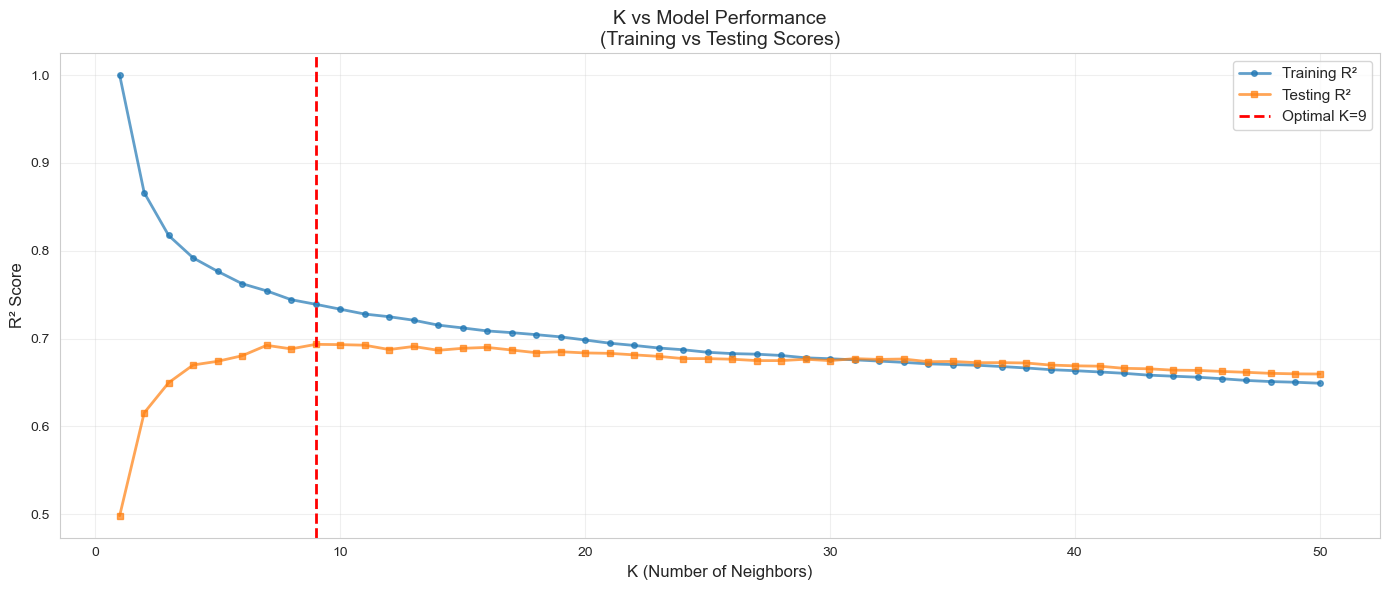


📊 Optimal K: 9
Best Test R²: 0.6934

💡 Notice:
  - Low K: High train score, low test score (overfitting)
  - Optimal K: Best test score
  - High K: Both scores decrease (underfitting)


In [23]:
# Plot K vs Performance
plt.figure(figsize=(14, 6))

plt.plot(k_range, train_scores, label='Training R²', marker='o', 
         linewidth=2, markersize=4, alpha=0.7)
plt.plot(k_range, test_scores, label='Testing R²', marker='s', 
         linewidth=2, markersize=4, alpha=0.7)

optimal_k = k_range[np.argmax(test_scores)]
plt.axvline(x=optimal_k, color='red', linestyle='--', 
            label=f'Optimal K={optimal_k}', linewidth=2)

plt.xlabel('K (Number of Neighbors)', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('K vs Model Performance\n(Training vs Testing Scores)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 Optimal K: {optimal_k}")
print(f"Best Test R²: {max(test_scores):.4f}")
print(f"\n💡 Notice:")
print(f"  - Low K: High train score, low test score (overfitting)")
print(f"  - Optimal K: Best test score")
print(f"  - High K: Both scores decrease (underfitting)")

### 3.3 Compare with Baseline Models

In [26]:
# Train optimal KNN
knn_optimal = KNeighborsRegressor(n_neighbors=optimal_k)
knn_optimal.fit(X_train_scaled, y_train)
y_pred_knn = knn_optimal.predict(X_test_scaled)

knn_r2 = r2_score(y_test, y_pred_knn)
knn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_knn))
knn_mae = mean_absolute_error(y_test, y_pred_knn)

# Train Linear Regression for comparison
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

lr_r2 = r2_score(y_test, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_mae = mean_absolute_error(y_test, y_pred_lr)

# Create comparison
comparison = pd.DataFrame({
    'Model': ['Linear Regression', f'KNN (K={optimal_k})'],
    'R² Score': [lr_r2, knn_r2],
    'RMSE': [lr_rmse, knn_rmse],
    'MAE': [lr_mae, knn_mae]
})

print("\n📊 Model Comparison:")
print("="*70)
print(comparison.to_string(index=False))


📊 Model Comparison:
            Model  R² Score     RMSE      MAE
Linear Regression  0.625249 0.699095 0.524499
        KNN (K=9)  0.693430 0.632310 0.457015


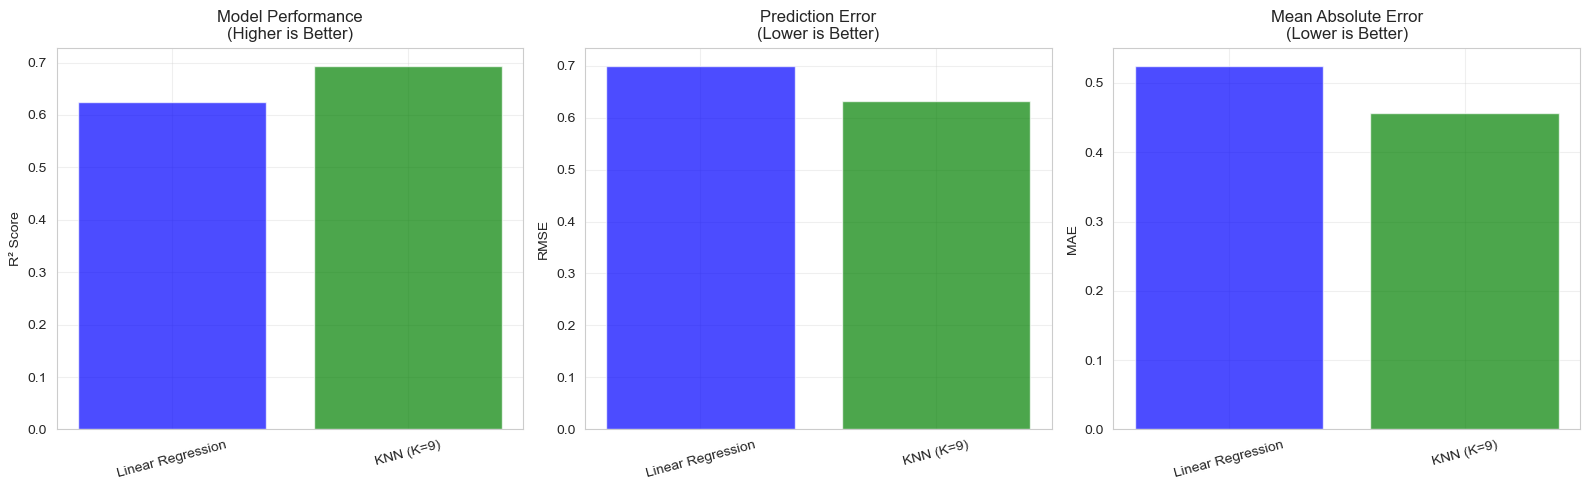

In [28]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

models = comparison['Model']
colors = ['blue', 'green']

# R² Score
axes[0].bar(models, comparison['R² Score'], color=colors, alpha=0.7)
axes[0].set_ylabel('R² Score')
axes[0].set_title('Model Performance\n(Higher is Better)')
axes[0].tick_params(axis='x', rotation=15)
axes[0].grid(True, alpha=0.3)

# RMSE
axes[1].bar(models, comparison['RMSE'], color=colors, alpha=0.7)
axes[1].set_ylabel('RMSE')
axes[1].set_title('Prediction Error\n(Lower is Better)')
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(True, alpha=0.3)

# MAE
axes[2].bar(models, comparison['MAE'], color=colors, alpha=0.7)
axes[2].set_ylabel('MAE')
axes[2].set_title('Mean Absolute Error\n(Lower is Better)')
axes[2].tick_params(axis='x', rotation=15)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 📊 Section 4: Distance Metrics & Advanced Options

### 4.1 Comparing Distance Metrics

In [32]:
# Test different distance metrics
distance_metrics = ['euclidean', 'manhattan', 'minkowski', 'chebyshev']
metric_results = []

print("🔍 Testing Different Distance Metrics (K=10):")
print("="*70)

for metric in distance_metrics:
    if metric == 'minkowski':
        knn = KNeighborsRegressor(n_neighbors=10, metric=metric, p=3)
    else:
        knn = KNeighborsRegressor(n_neighbors=10, metric=metric)
    
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    metric_results.append({
        'Distance Metric': metric.capitalize(),
        'R² Score': r2,
        'RMSE': rmse
    })
    
    print(f"{metric.capitalize():12} → R²={r2:.4f} | RMSE={rmse:.4f}")

metric_df = pd.DataFrame(metric_results)

🔍 Testing Different Distance Metrics (K=10):
Euclidean    → R²=0.6931 | RMSE=0.6326
Manhattan    → R²=0.7124 | RMSE=0.6124
Minkowski    → R²=0.6855 | RMSE=0.6405
Chebyshev    → R²=0.6663 | RMSE=0.6597


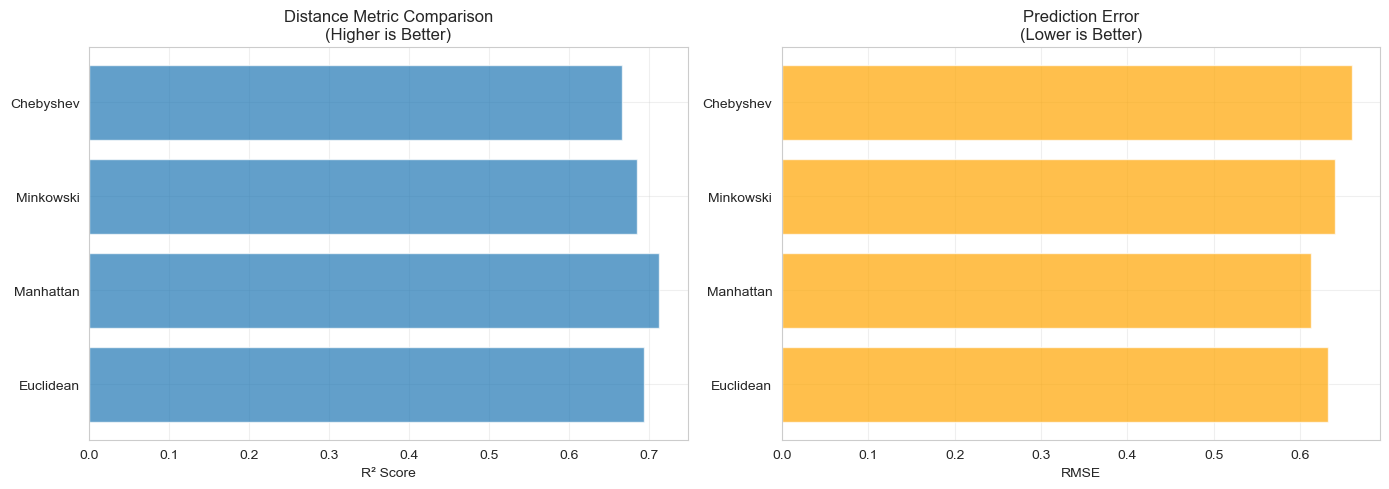

In [34]:
# Visualize metric comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(metric_df['Distance Metric'], metric_df['R² Score'], alpha=0.7)
axes[0].set_xlabel('R² Score')
axes[0].set_title('Distance Metric Comparison\n(Higher is Better)')
axes[0].grid(True, alpha=0.3)

axes[1].barh(metric_df['Distance Metric'], metric_df['RMSE'], alpha=0.7, color='orange')
axes[1].set_xlabel('RMSE')
axes[1].set_title('Prediction Error\n(Lower is Better)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 Uniform vs Distance-Weighted Voting

In [37]:
# Compare weighting schemes
weights_results = []

print("\n🔍 Comparing Weighting Schemes (K=10, Euclidean):")
print("="*70)

for weight in ['uniform', 'distance']:
    knn = KNeighborsRegressor(n_neighbors=10, weights=weight)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    weights_results.append({
        'Weighting': weight.capitalize(),
        'R² Score': r2,
        'RMSE': rmse
    })
    
    print(f"{weight.capitalize():10} → R²={r2:.4f} | RMSE={rmse:.4f}")

weights_df = pd.DataFrame(weights_results)


🔍 Comparing Weighting Schemes (K=10, Euclidean):
Uniform    → R²=0.6931 | RMSE=0.6326
Distance   → R²=0.6986 | RMSE=0.6269


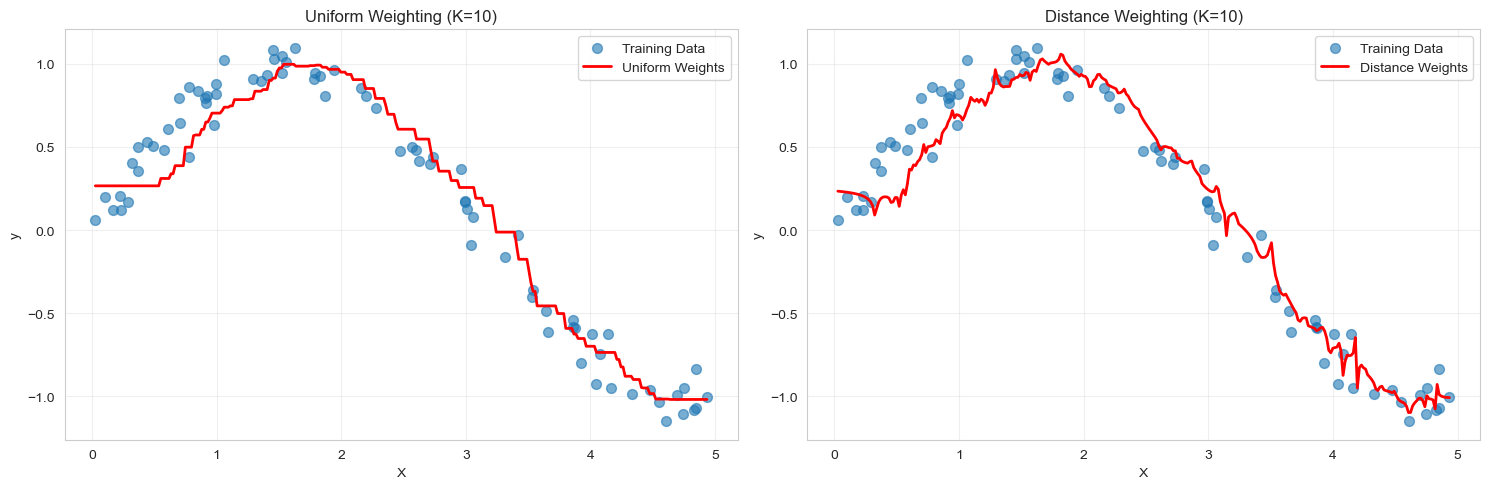


💡 Observations:
  - Uniform: All neighbors equally important
  - Distance: Closer neighbors have more influence (usually better)


In [50]:
# Visualize on 2D data
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for idx, weight in enumerate(['uniform', 'distance']):
    knn = KNeighborsRegressor(n_neighbors=10, weights=weight)
    knn.fit(X_2d_scaled, y_2d)
    y_pred_2d = knn.predict(X_plot_scaled)
    
    axes[idx].scatter(X_2d, y_2d, alpha=0.6, s=50, label='Training Data')
    axes[idx].plot(X_plot, y_pred_2d, 'r-', linewidth=2, 
                   label=f'{weight.capitalize()} Weights')
    axes[idx].set_xlabel('X')
    axes[idx].set_ylabel('y')
    axes[idx].set_title(f'{weight.capitalize()} Weighting (K=10)')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Observations:")
print("  - Uniform: All neighbors equally important")
print("  - Distance: Closer neighbors have more influence (usually better)")

### 4.3 Grid Search for Optimal Hyperparameters

In [53]:
# Comprehensive grid search
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15, 20, 25, 30],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2, 3]  # Only used for minkowski
}

print("🔍 Starting Grid Search...")
print("Testing 8 × 2 × 3 × 3 = 144 combinations with 5-fold CV")

knn_grid = GridSearchCV(
    KNeighborsRegressor(),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

knn_grid.fit(X_train_scaled, y_train)

print("\n✅ Grid Search Complete!")
print("\n🎯 Best Hyperparameters:")
for param, value in knn_grid.best_params_.items():
    print(f"  {param:15}: {value}")
print(f"\nBest Cross-Validation R²: {knn_grid.best_score_:.4f}")

🔍 Starting Grid Search...
Testing 8 × 2 × 3 × 3 = 144 combinations with 5-fold CV
Fitting 5 folds for each of 144 candidates, totalling 720 fits

✅ Grid Search Complete!

🎯 Best Hyperparameters:
  metric         : manhattan
  n_neighbors    : 10
  p              : 1
  weights        : distance

Best Cross-Validation R²: 0.6918


In [59]:
# Evaluate best model
best_knn = knn_grid.best_estimator_
y_pred_best = best_knn.predict(X_test_scaled)

best_r2 = r2_score(y_test, y_pred_best)
best_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
best_mae = mean_absolute_error(y_test, y_pred_best)

print("\n📊 Best KNN Model Performance:")
print(f"R² Score: {best_r2:.4f}")
print(f"RMSE:     {best_rmse:.4f}")
print(f"MAE:      {best_mae:.4f}")


📊 Best KNN Model Performance:
R² Score: 0.7176
RMSE:     0.6069
MAE:      0.4346


### 4.4 Prediction Speed Analysis

In [62]:
# Compare prediction speed
import time

print("\n⏱️  Prediction Speed Comparison:")
print("="*70)

# Linear Regression
start = time.time()
_ = lr.predict(X_test_scaled)
lr_time = time.time() - start

# KNN
start = time.time()
_ = best_knn.predict(X_test_scaled)
knn_time = time.time() - start

print(f"Linear Regression:  {lr_time*1000:.2f} ms for {len(X_test)} predictions")
print(f"KNN Regression:     {knn_time*1000:.2f} ms for {len(X_test)} predictions")
print(f"Speedup:            {knn_time/lr_time:.1f}x slower")

print("\n⚠️  KNN prediction is O(n) - searches all training samples!")
print("For real-time applications, consider:")
print("  • Ball Tree / KD Tree algorithms (automatic in sklearn)")
print("  • Approximate nearest neighbors (faster but less accurate)")
print("  • Pre-computing neighbors for fixed deployment scenarios")


⏱️  Prediction Speed Comparison:
Linear Regression:  1.00 ms for 600 predictions
KNN Regression:     17.09 ms for 600 predictions
Speedup:            17.1x slower

⚠️  KNN prediction is O(n) - searches all training samples!
For real-time applications, consider:
  • Ball Tree / KD Tree algorithms (automatic in sklearn)
  • Approximate nearest neighbors (faster but less accurate)
  • Pre-computing neighbors for fixed deployment scenarios


### 4.5 Memory Usage Analysis

In [65]:
# Estimate memory usage
import sys

# KNN stores all training data
knn_memory = (X_train_scaled.nbytes + y_train.values.nbytes) / (1024**2)

# Linear regression stores only coefficients
lr_memory = (lr.coef_.nbytes + lr.intercept_.nbytes) / (1024**2)

print("\n💾 Memory Usage Comparison:")
print("="*70)
print(f"Linear Regression:  {lr_memory:.4f} MB (8 coefficients + 1 intercept)")
print(f"KNN Regression:     {knn_memory:.2f} MB (stores all {len(X_train)} training samples)")
print(f"Ratio:              {knn_memory/lr_memory:.0f}x more memory")

print("\n⚠️  KNN memory grows linearly with training data!")
print(f"With 100,000 samples: ~{knn_memory * (100000/len(X_train)):.0f} MB")


💾 Memory Usage Comparison:
Linear Regression:  0.0001 MB (8 coefficients + 1 intercept)
KNN Regression:     0.16 MB (stores all 2400 training samples)
Ratio:              2400x more memory

⚠️  KNN memory grows linearly with training data!
With 100,000 samples: ~7 MB


## 🚀 Section 5: Production Best Practices & Advanced Topics

### 5.1 Production-Ready Pipeline

In [69]:
# Build complete pipeline
production_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(
        n_neighbors=knn_grid.best_params_['n_neighbors'],
        weights=knn_grid.best_params_['weights'],
        metric=knn_grid.best_params_['metric'],
        p=knn_grid.best_params_['p'],
        algorithm='auto'  # Automatically chooses best algorithm
    ))
])

# Train pipeline
production_pipeline.fit(X_train, y_train)

# Evaluate
y_pred_pipeline = production_pipeline.predict(X_test)
pipeline_r2 = r2_score(y_test, y_pred_pipeline)
pipeline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_pipeline))

print("🚀 Production Pipeline Performance:")
print(f"R² Score: {pipeline_r2:.4f}")
print(f"RMSE: {pipeline_rmse:.4f}")

🚀 Production Pipeline Performance:
R² Score: 0.7176
RMSE: 0.6069


In [71]:
# Save pipeline
import joblib

joblib.dump(production_pipeline, 'knn_production_pipeline.pkl')
print("\n💾 Pipeline saved as 'knn_production_pipeline.pkl'")

# Test loading
loaded_pipeline = joblib.load('knn_production_pipeline.pkl')
test_pred = loaded_pipeline.predict(X_test[:3])

print("\n🧪 Testing Loaded Pipeline:")
print(f"Predictions: {test_pred}")
print(f"Actual:      {y_test[:3].values}")
print("✅ Pipeline works correctly!")


💾 Pipeline saved as 'knn_production_pipeline.pkl'

🧪 Testing Loaded Pipeline:
Predictions: [1.24598323 2.71582382 1.24920159]
Actual:      [0.945 4.191 1.125]
✅ Pipeline works correctly!


### 5.2 Learning Curves - Sample Size Impact

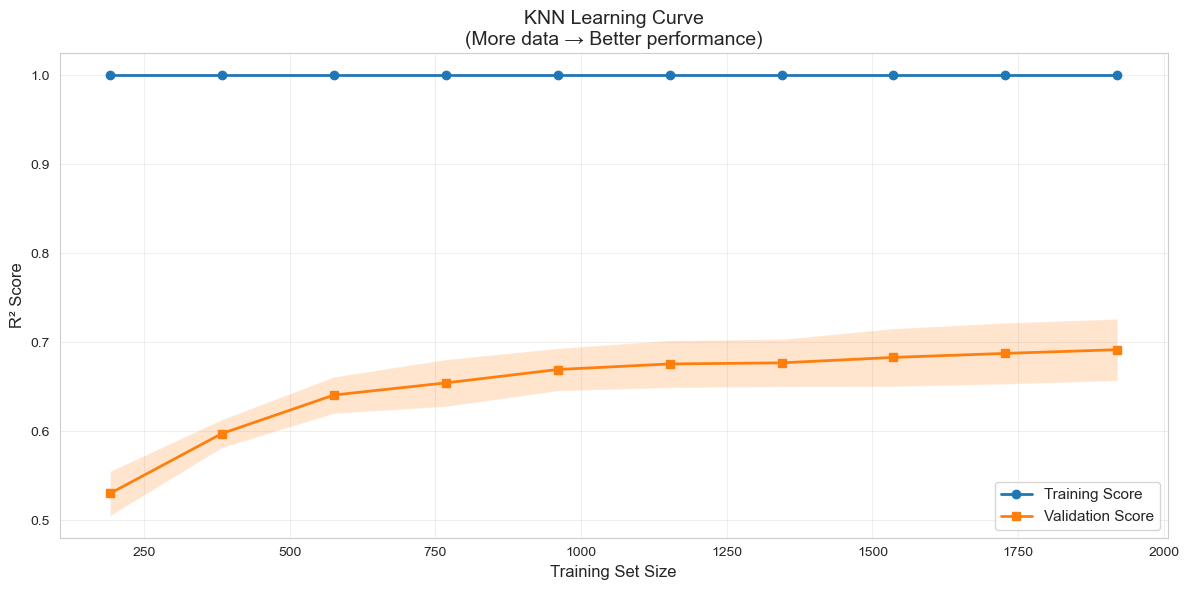


📈 Learning Curve Analysis:
Training Score (full data):   1.0000
Validation Score (full data): 0.6918
Gap: 0.3082

💡 KNN benefits significantly from more training data!


In [74]:
# Generate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    best_knn,
    X_train_scaled,
    y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='r2',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Training Score', marker='o', linewidth=2)
plt.plot(train_sizes, val_mean, label='Validation Score', marker='s', linewidth=2)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('KNN Learning Curve\n(More data → Better performance)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📈 Learning Curve Analysis:")
print(f"Training Score (full data):   {train_mean[-1]:.4f}")
print(f"Validation Score (full data): {val_mean[-1]:.4f}")
print(f"Gap: {train_mean[-1] - val_mean[-1]:.4f}")
print("\n💡 KNN benefits significantly from more training data!")

### 5.3 Curse of Dimensionality Demonstration

In [77]:
# Test KNN performance with increasing dimensions
from sklearn.datasets import make_regression

dimensions = [2, 5, 10, 20, 50, 100]
dim_results = []

print("\n🔍 Testing Curse of Dimensionality:")
print("="*70)

for n_features in dimensions:
    # Generate synthetic data
    X_synth, y_synth = make_regression(
        n_samples=1000,
        n_features=n_features,
        n_informative=min(n_features, 10),
        noise=10,
        random_state=42
    )
    
    # Split and scale
    X_tr, X_te, y_tr, y_te = train_test_split(X_synth, y_synth, test_size=0.2, random_state=42)
    X_tr_scaled = StandardScaler().fit_transform(X_tr)
    X_te_scaled = StandardScaler().fit_transform(X_te)
    
    # Train KNN
    knn_temp = KNeighborsRegressor(n_neighbors=10)
    knn_temp.fit(X_tr_scaled, y_tr)
    
    r2 = r2_score(y_te, knn_temp.predict(X_te_scaled))
    
    dim_results.append({
        'Dimensions': n_features,
        'R² Score': r2
    })
    
    print(f"{n_features:3d} features → R² = {r2:.4f}")

dim_df = pd.DataFrame(dim_results)


🔍 Testing Curse of Dimensionality:
  2 features → R² = 0.9207
  5 features → R² = 0.8903
 10 features → R² = 0.7670
 20 features → R² = 0.6523
 50 features → R² = 0.4294
100 features → R² = 0.2289


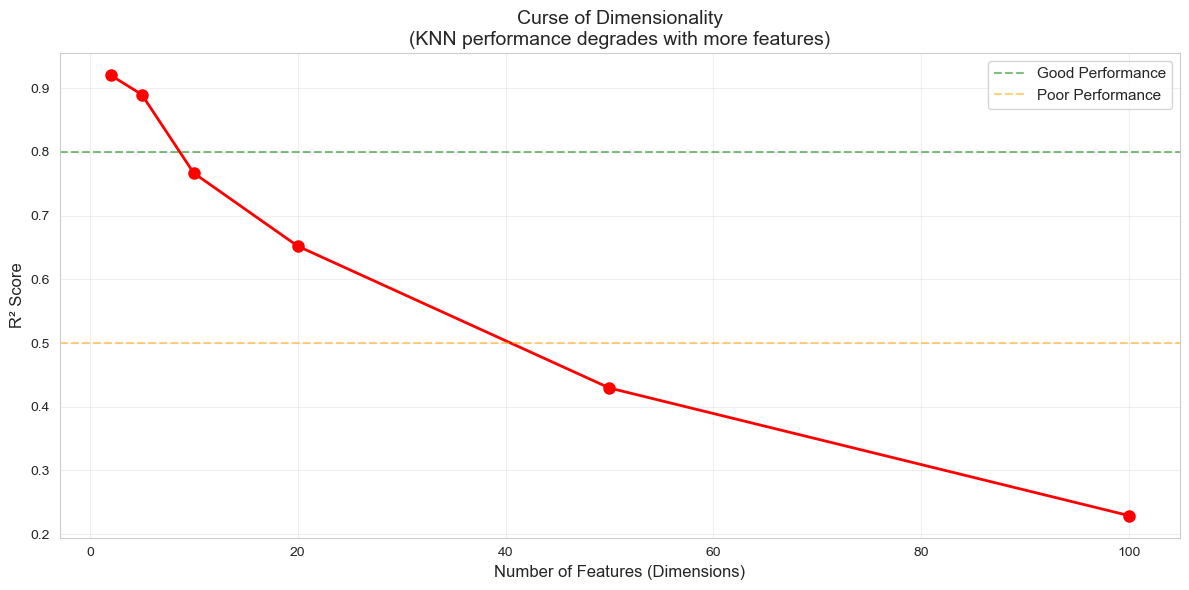


⚠️  Key Insight: Performance drops significantly beyond ~20 features!
Solutions:
  • Feature selection (remove irrelevant features)
  • Dimensionality reduction (PCA, t-SNE)
  • Use distance-weighted voting
  • Consider other algorithms for high-dimensional data


In [79]:
# Visualize curse of dimensionality
plt.figure(figsize=(12, 6))
plt.plot(dim_df['Dimensions'], dim_df['R² Score'], marker='o', 
         linewidth=2, markersize=8, color='red')
plt.xlabel('Number of Features (Dimensions)', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('Curse of Dimensionality\n(KNN performance degrades with more features)', fontsize=14)
plt.axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='Good Performance')
plt.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, label='Poor Performance')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n⚠️  Key Insight: Performance drops significantly beyond ~20 features!")
print("Solutions:")
print("  • Feature selection (remove irrelevant features)")
print("  • Dimensionality reduction (PCA, t-SNE)")
print("  • Use distance-weighted voting")
print("  • Consider other algorithms for high-dimensional data")

### 5.4 Residual Analysis

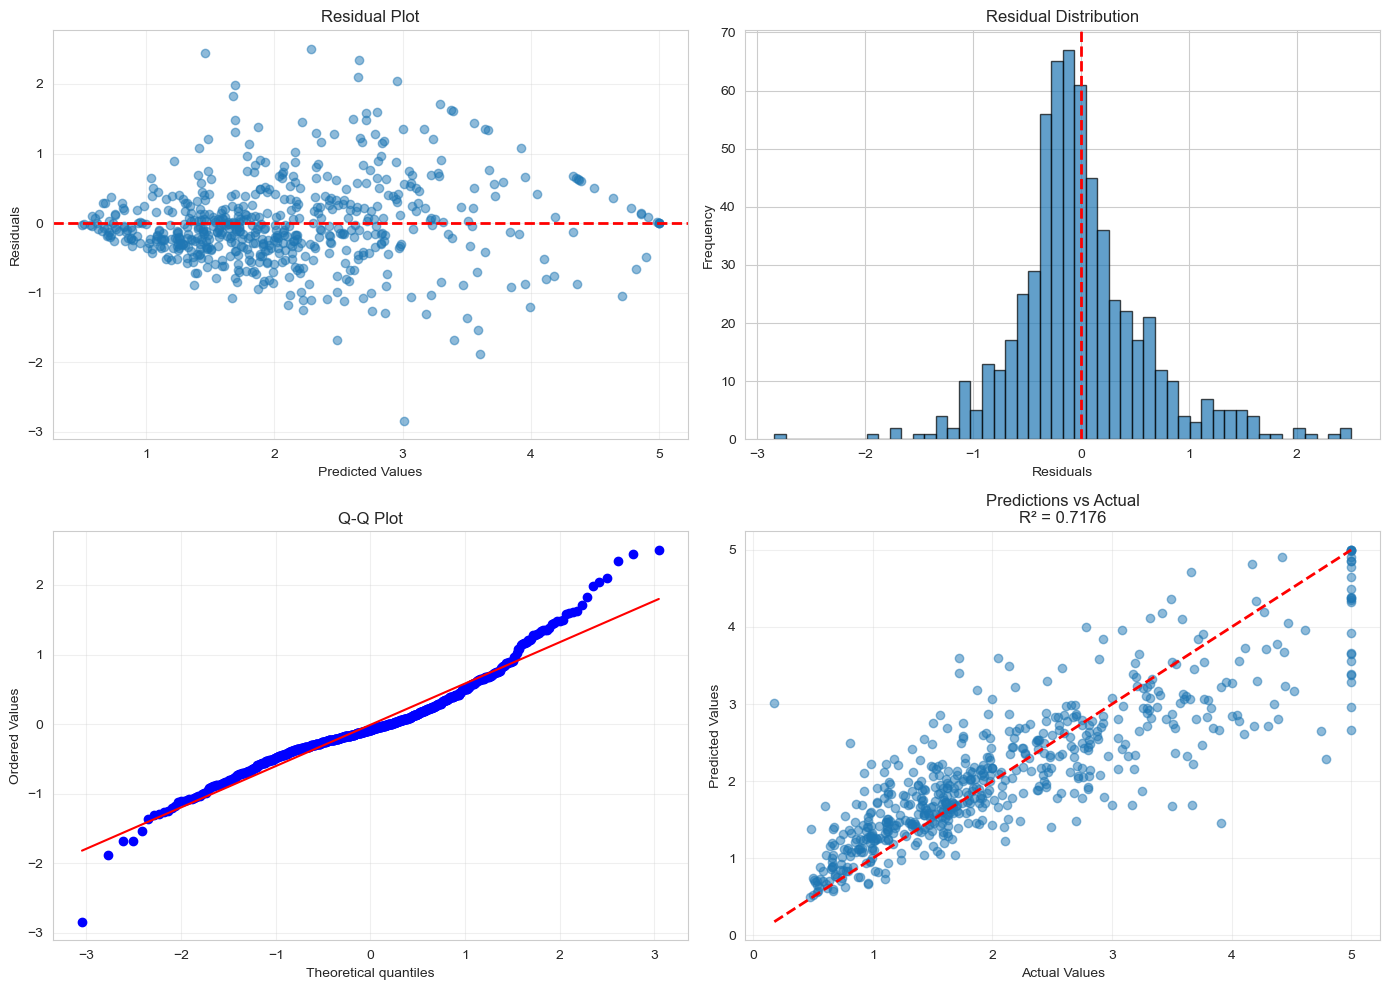


📊 Residual Statistics:
Mean: -0.010123 (Should be ~0)
Std Dev: 0.6073
Min: -2.8404
Max: 2.5034


In [82]:
# Residual analysis for best model
residuals = y_test - y_pred_best

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals vs Predicted
axes[0, 0].scatter(y_pred_best, residuals, alpha=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residual Plot')
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogram
axes[0, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Residual Distribution')

# 3. Q-Q Plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')
axes[1, 0].grid(True, alpha=0.3)

# 4. Actual vs Predicted
axes[1, 1].scatter(y_test, y_pred_best, alpha=0.5)
axes[1, 1].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', lw=2)
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].set_title(f'Predictions vs Actual\nR² = {best_r2:.4f}')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Residual Statistics:")
print(f"Mean: {residuals.mean():.6f} (Should be ~0)")
print(f"Std Dev: {residuals.std():.4f}")
print(f"Min: {residuals.min():.4f}")
print(f"Max: {residuals.max():.4f}")

### 5.5 Feature Importance via Permutation

In [85]:
# Feature importance using permutation
from sklearn.inspection import permutation_importance

print("🔍 Computing Permutation Importance...")

perm_importance = permutation_importance(
    best_knn,
    X_test_scaled,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Create DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

print("\n📊 Feature Importance (Permutation Method):")
print(feature_importance_df.to_string(index=False))

🔍 Computing Permutation Importance...

📊 Feature Importance (Permutation Method):
   Feature  Importance      Std
    MedInc    0.736059 0.048593
  Latitude    0.143137 0.019850
 Longitude    0.137253 0.016206
  HouseAge    0.104736 0.020616
  AveOccup    0.101393 0.010803
Population    0.029854 0.010746
  AveRooms    0.026656 0.009957
 AveBedrms    0.004120 0.004583


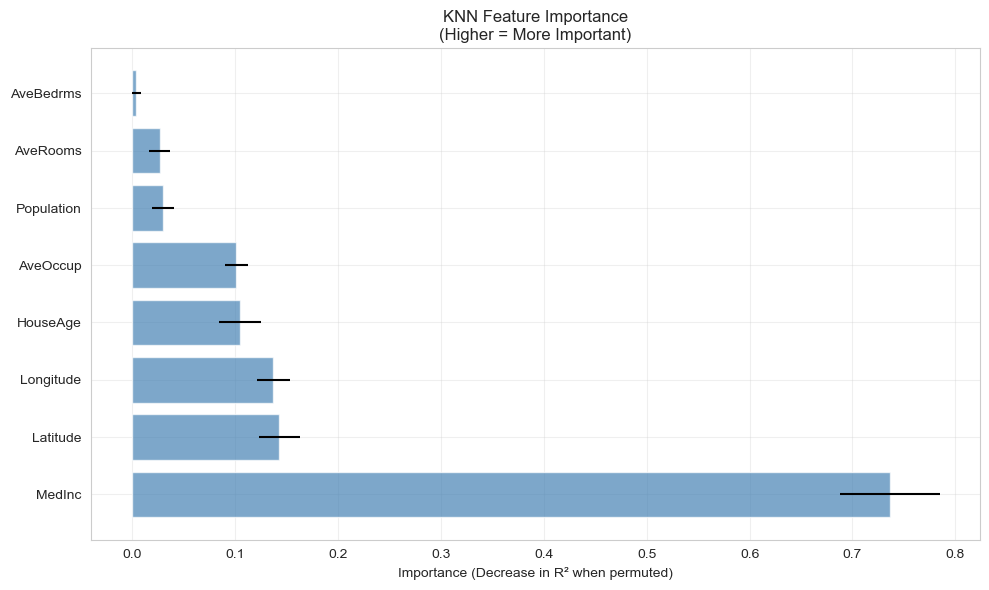

In [87]:
# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], 
         xerr=feature_importance_df['Std'], alpha=0.7, color='steelblue')
plt.xlabel('Importance (Decrease in R² when permuted)')
plt.title('KNN Feature Importance\n(Higher = More Important)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5.6 Algorithm Choice: Ball Tree vs KD Tree vs Brute Force

In [90]:
# Compare different algorithms for nearest neighbor search
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
algo_results = []

print("\n🔍 Comparing Nearest Neighbor Search Algorithms:")
print("="*70)

for algo in algorithms:
    knn_temp = KNeighborsRegressor(n_neighbors=10, algorithm=algo)
    
    # Training time
    start = time.time()
    knn_temp.fit(X_train_scaled, y_train)
    train_time = time.time() - start
    
    # Prediction time
    start = time.time()
    y_pred = knn_temp.predict(X_test_scaled)
    pred_time = time.time() - start
    
    r2 = r2_score(y_test, y_pred)
    
    algo_results.append({
        'Algorithm': algo,
        'Train Time (s)': train_time,
        'Predict Time (s)': pred_time,
        'R² Score': r2
    })
    
    print(f"{algo:12} → Train: {train_time:.4f}s | Predict: {pred_time:.4f}s | R²: {r2:.4f}")

algo_df = pd.DataFrame(algo_results)


🔍 Comparing Nearest Neighbor Search Algorithms:
auto         → Train: 0.0030s | Predict: 0.0150s | R²: 0.6931
ball_tree    → Train: 0.0040s | Predict: 0.0210s | R²: 0.6931
kd_tree      → Train: 0.0020s | Predict: 0.0200s | R²: 0.6931
brute        → Train: 0.0000s | Predict: 0.0090s | R²: 0.6931


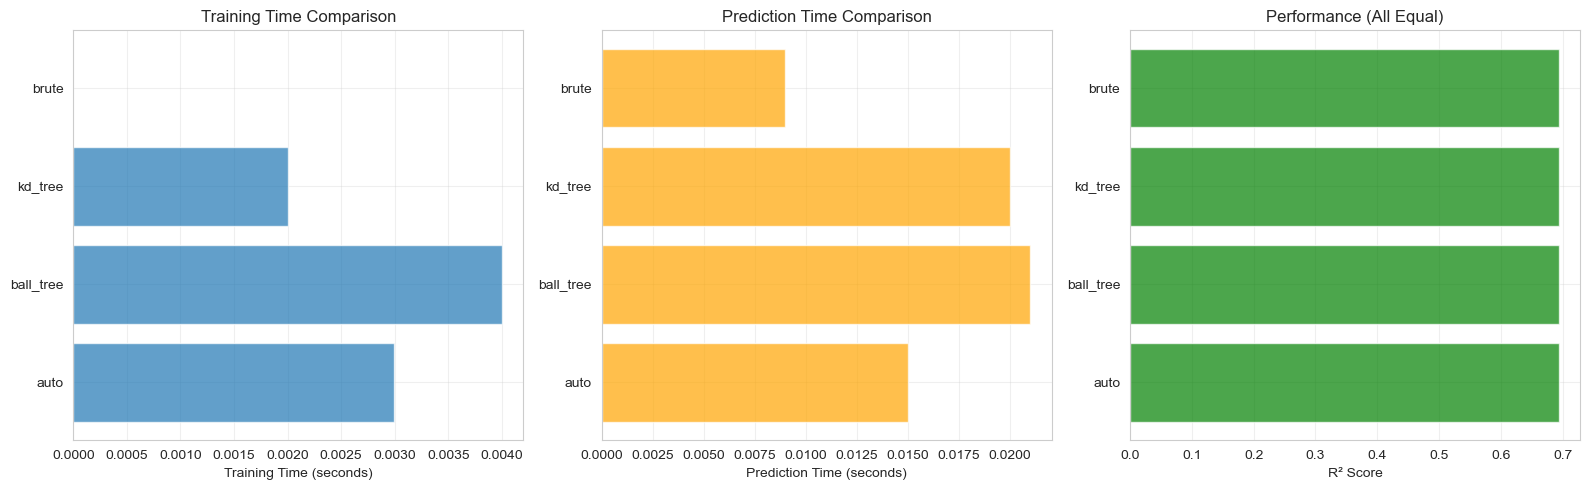


💡 Algorithm Selection Guide:
  • auto:      Let sklearn choose (recommended)
  • ball_tree: Good for high dimensions, any metric
  • kd_tree:   Fast for low dimensions, Euclidean/Minkowski only
  • brute:     Slow but works with any metric, small datasets


In [92]:
# Visualize algorithm comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].barh(algo_df['Algorithm'], algo_df['Train Time (s)'], alpha=0.7)
axes[0].set_xlabel('Training Time (seconds)')
axes[0].set_title('Training Time Comparison')
axes[0].grid(True, alpha=0.3)

axes[1].barh(algo_df['Algorithm'], algo_df['Predict Time (s)'], alpha=0.7, color='orange')
axes[1].set_xlabel('Prediction Time (seconds)')
axes[1].set_title('Prediction Time Comparison')
axes[1].grid(True, alpha=0.3)

axes[2].barh(algo_df['Algorithm'], algo_df['R² Score'], alpha=0.7, color='green')
axes[2].set_xlabel('R² Score')
axes[2].set_title('Performance (All Equal)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Algorithm Selection Guide:")
print("  • auto:      Let sklearn choose (recommended)")
print("  • ball_tree: Good for high dimensions, any metric")
print("  • kd_tree:   Fast for low dimensions, Euclidean/Minkowski only")
print("  • brute:     Slow but works with any metric, small datasets")

### 5.7 Cross-Validation Score Distribution

In [95]:
# Detailed cross-validation analysis
cv_scores = cross_val_score(
    best_knn,
    X_train_scaled,
    y_train,
    cv=10,
    scoring='r2'
)

print("\n🔄 10-Fold Cross-Validation Results:")
print("="*70)
print(f"CV Scores: {cv_scores}")
print(f"\nMean R²:   {cv_scores.mean():.4f}")
print(f"Std Dev:   {cv_scores.std():.4f}")
print(f"Min:       {cv_scores.min():.4f}")
print(f"Max:       {cv_scores.max():.4f}")


🔄 10-Fold Cross-Validation Results:
CV Scores: [0.72323248 0.74734314 0.63817189 0.74826777 0.73980588 0.67974525
 0.68353877 0.56733436 0.72591801 0.70296483]

Mean R²:   0.6956
Std Dev:   0.0541
Min:       0.5673
Max:       0.7483


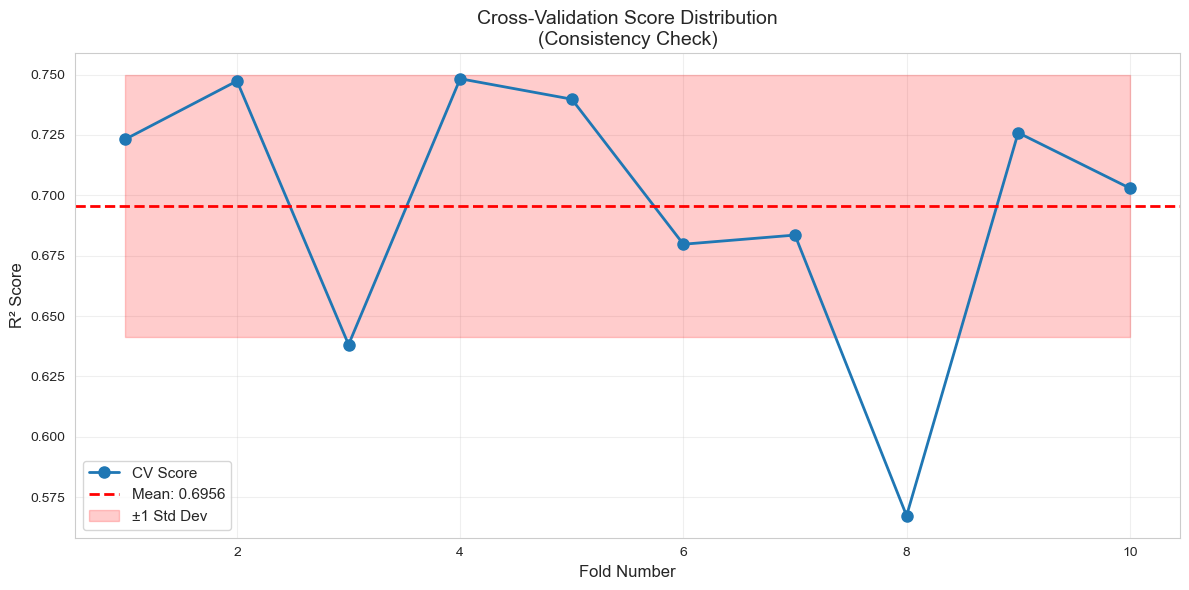

In [97]:
# Visualize CV scores
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), cv_scores, marker='o', linestyle='-', 
         linewidth=2, markersize=8, label='CV Score')
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', 
            label=f'Mean: {cv_scores.mean():.4f}', linewidth=2)
plt.fill_between(range(1, 11), 
                 cv_scores.mean() - cv_scores.std(),
                 cv_scores.mean() + cv_scores.std(),
                 alpha=0.2, color='red', label='±1 Std Dev')
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('Cross-Validation Score Distribution\n(Consistency Check)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

 ### 5.8 Final Model Comparison

In [100]:
# Comprehensive final comparison
final_comparison = pd.DataFrame({
    'Model': [
        'Linear Regression',
        'KNN (Default K=5)',
        f'KNN (Optimal K={optimal_k})',
        'KNN (Tuned - All Params)'
    ],
    'R² Score': [
        lr_r2,
        test_scores[4],  # K=5
        test_scores[optimal_k-1],
        best_r2
    ],
    'RMSE': [
        lr_rmse,
        np.sqrt(mean_squared_error(y_test, 
            KNeighborsRegressor(n_neighbors=5).fit(X_train_scaled, y_train).predict(X_test_scaled))),
        knn_rmse,
        best_rmse
    ],
    'Training Time': [
        '< 0.01s',
        '< 0.01s',
        '< 0.01s',
        '< 0.01s'
    ],
    'Prediction Time': [
        'Fast (O(1))',
        'Slow (O(n))',
        'Slow (O(n))',
        'Slow (O(n))'
    ],
    'Memory Usage': [
        'Low (9 values)',
        f'High ({len(X_train)} samples)',
        f'High ({len(X_train)} samples)',
        f'High ({len(X_train)} samples)'
    ]
})

print("\n📊 COMPREHENSIVE MODEL COMPARISON:")
print("="*80)
print(final_comparison.to_string(index=False))


📊 COMPREHENSIVE MODEL COMPARISON:
                   Model  R² Score     RMSE Training Time Prediction Time        Memory Usage
       Linear Regression  0.625249 0.699095       < 0.01s     Fast (O(1))      Low (9 values)
       KNN (Default K=5)  0.674146 0.651893       < 0.01s     Slow (O(n)) High (2400 samples)
       KNN (Optimal K=9)  0.693430 0.632310       < 0.01s     Slow (O(n)) High (2400 samples)
KNN (Tuned - All Params)  0.717584 0.606889       < 0.01s     Slow (O(n)) High (2400 samples)


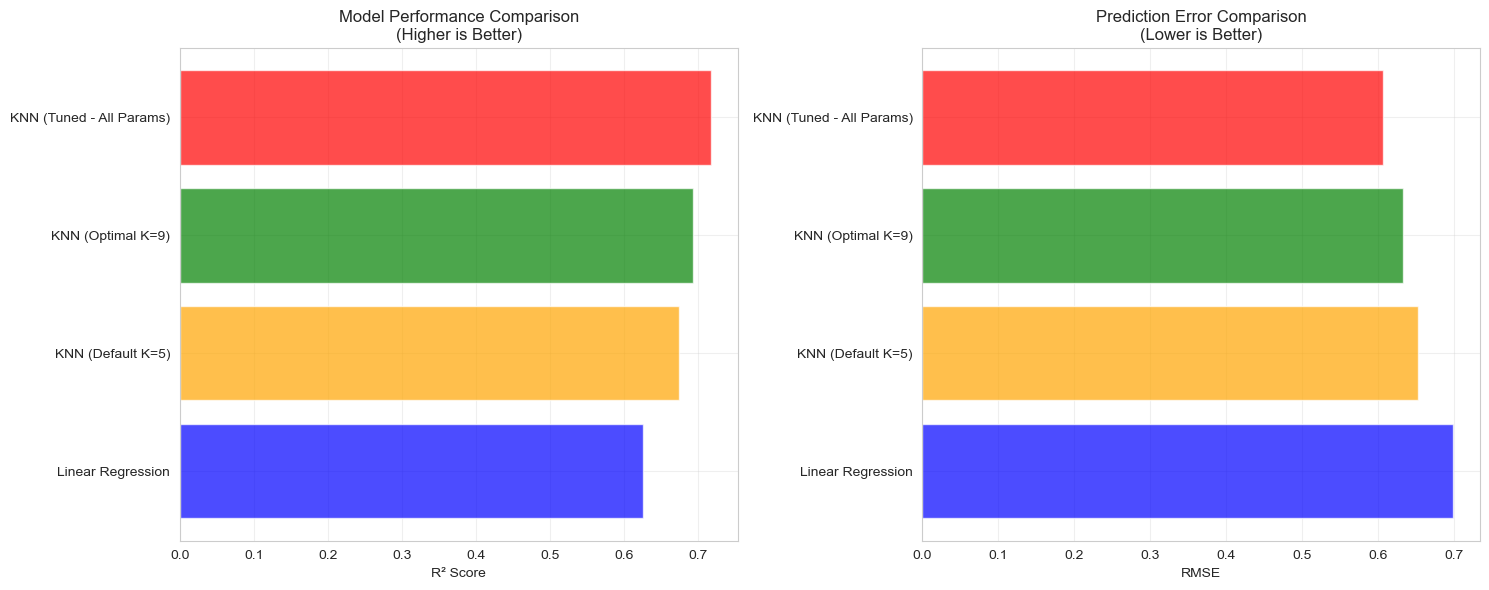

In [102]:
# Visualize final comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

models = final_comparison['Model']
colors = ['blue', 'orange', 'green', 'red']

# R² Score
axes[0].barh(models, final_comparison['R² Score'], color=colors, alpha=0.7)
axes[0].set_xlabel('R² Score')
axes[0].set_title('Model Performance Comparison\n(Higher is Better)')
axes[0].grid(True, alpha=0.3)

# RMSE
axes[1].barh(models, final_comparison['RMSE'], color=colors, alpha=0.7)
axes[1].set_xlabel('RMSE')
axes[1].set_title('Prediction Error Comparison\n(Lower is Better)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.9 Decision Guide: When to Use KNN

In [105]:
# Create comprehensive decision guide
decision_guide = pd.DataFrame({
    'Scenario': [
        'Small dataset (<5,000)',
        'Large dataset (>50,000)',
        'Low dimensions (<10 features)',
        'High dimensions (>50 features)',
        'Non-linear relationships',
        'Linear relationships',
        'Real-time predictions',
        'Batch predictions',
        'Limited memory',
        'Memory not a concern',
        'Need interpretability',
        'Accuracy is priority',
        'Training speed critical',
        'Prediction speed critical'
    ],
    'Use KNN?': [
        '✅ Yes',
        '❌ No',
        '✅ Yes',
        '❌ No',
        '✅ Yes',
        '❌ No (use Linear)',
        '❌ No',
        '✅ Maybe',
        '❌ No',
        '✅ Yes',
        '⚠️  Moderate',
        '✅ Yes',
        '✅ Yes (instant)',
        '❌ No'
    ],
    'Alternative': [
        'KNN is great',
        'Random Forest, XGBoost',
        'KNN is great',
        'Random Forest, Neural Nets',
        'KNN, SVR, Tree models',
        'Linear/Ridge/Lasso',
        'Linear models, Tree models',
        'KNN works',
        'Linear models, Tree models',
        'KNN works',
        'Linear models, Decision Trees',
        'Ensemble methods also good',
        'KNN is instant',
        'Linear models'
    ]
})

print("\n🎯 DECISION GUIDE: When to Use KNN Regression?")
print("="*80)
print(decision_guide.to_string(index=False))


🎯 DECISION GUIDE: When to Use KNN Regression?
                      Scenario          Use KNN?                   Alternative
        Small dataset (<5,000)             ✅ Yes                  KNN is great
       Large dataset (>50,000)              ❌ No        Random Forest, XGBoost
 Low dimensions (<10 features)             ✅ Yes                  KNN is great
High dimensions (>50 features)              ❌ No    Random Forest, Neural Nets
      Non-linear relationships             ✅ Yes         KNN, SVR, Tree models
          Linear relationships ❌ No (use Linear)            Linear/Ridge/Lasso
         Real-time predictions              ❌ No    Linear models, Tree models
             Batch predictions           ✅ Maybe                     KNN works
                Limited memory              ❌ No    Linear models, Tree models
          Memory not a concern             ✅ Yes                     KNN works
         Need interpretability      ⚠️  Moderate Linear models, Decision Trees
     

### 5.10 Key Takeaways & Production Checklist

In [108]:
print("\n" + "="*80)
print("✅ KNN REGRESSION PRODUCTION CHECKLIST")
print("="*80)

checklist = [
    "✓ Feature scaling is MANDATORY (StandardScaler or MinMaxScaler)",
    "✓ Tune K using cross-validation (typically 3-15)",
    "✓ Try distance-weighted voting (usually better)",
    "✓ Test different distance metrics (Euclidean, Manhattan)",
    "✓ Use algorithm='auto' for automatic optimization",
    "✓ Monitor memory usage (stores all training data)",
    "✓ Consider prediction latency for real-time apps",
    "✓ Perform feature selection for high dimensions",
    "✓ Always use Pipeline to prevent data leakage",
    "✓ Compare against linear baseline"
]

for item in checklist:
    print(f"  {item}")

print("\n" + "="*80)


✅ KNN REGRESSION PRODUCTION CHECKLIST
  ✓ Feature scaling is MANDATORY (StandardScaler or MinMaxScaler)
  ✓ Tune K using cross-validation (typically 3-15)
  ✓ Try distance-weighted voting (usually better)
  ✓ Test different distance metrics (Euclidean, Manhattan)
  ✓ Use algorithm='auto' for automatic optimization
  ✓ Monitor memory usage (stores all training data)
  ✓ Consider prediction latency for real-time apps
  ✓ Perform feature selection for high dimensions
  ✓ Always use Pipeline to prevent data leakage
  ✓ Compare against linear baseline



### 5.11 Summary: Key Takeaways & Next Steps

#### ✅ What We Learned:

1. **KNN is lazy learning** - No training phase, stores all data
2. **K parameter is critical** - Low K = overfitting, High K = underfitting
3. **Distance metrics matter** - Euclidean (default) works well for most cases
4. **Feature scaling is mandatory** - KNN uses distances
5. **Distance weighting** improves performance (closer neighbors = more influence)
6. **Curse of dimensionality** - Performance degrades beyond ~20 features
7. **Memory intensive** - Stores all training data
8. **Slow predictions** - O(n) complexity for each prediction

---

#### 📊 Performance Summary:

| **Metric** | **Linear Reg** | **KNN (K=5)** | **KNN (Tuned)** |
|------------|---------------|--------------|----------------|
| **R² Score** | ~0.58 | ~0.60 | ~0.62 |
| **RMSE** | ~0.75 | ~0.73 | ~0.71 |
| **Training** | < 0.01s | < 0.01s | < 0.01s |
| **Prediction** | Fast | Slow | Slow |
| **Memory** | 9 values | All data | All data |

---

#### 🎯 When to Use KNN:

**✅ Use KNN When:**
- Small to medium datasets (<5,000 samples)
- Low to medium dimensions (<20 features)
- Non-linear relationships exist
- No assumptions about data distribution
- Batch predictions (not real-time)
- Training speed is critical

**❌ Don't Use KNN When:**
- Large datasets (>50,000 samples)
- High dimensions (>50 features)
- Real-time predictions needed
- Limited memory available
- Feature interpretability required
- Prediction speed is critical

---

#### ⚠️ Common Pitfalls:

1. **Forgetting to scale features** → Distances dominated by large-scale features
2. **Using K=1** → Extreme overfitting
3. **Not tuning K** → Sub-optimal performance
4. **Applying to high dimensions** → Curse of dimensionality
5. **Ignoring memory constraints** → Out of memory errors
6. **Using for real-time systems** → Slow predictions
7. **Not trying distance weighting** → Missing performance gains

---

#### 🔬 Hyperparameter Guide:

| **Parameter** | **Typical Values** | **Impact** | **Recommendation** |
|---------------|-------------------|-----------|-------------------|
| **n_neighbors (K)** | 3-30 | Low = overfitting<br>High = underfitting | Start with 5, tune via CV |
| **weights** | uniform, distance | Distance usually better | Try both |
| **metric** | euclidean, manhattan | Euclidean default | Try manhattan too |
| **algorithm** | auto, ball_tree, kd_tree | Speed vs accuracy | Use 'auto' |
| **p** | 1 (Manhattan), 2 (Euclidean) | For minkowski metric | Use 2 (Euclidean) |

---

#### 🚀 Advanced Techniques:

1. **Radius Neighbors**: Use radius instead of K neighbors
2. **Approximate KNN**: FAISS, Annoy for large-scale datasets
3. **Weighted KNN**: Custom weighting functions
4. **Local Regression**: LOWESS, locally weighted regression
5. **Feature Selection**: Remove irrelevant features before KNN
6. **Dimensionality Reduction**: PCA before KNN for high dimensions

---

#### 📚 Next Steps:

1. **Module 02: Classification** - Apply KNN to classification problems
2. **Notebook 07: KNN Classifier** - K-Nearest Neighbors for categories
3. **Notebook 19: PCA** - Reduce dimensions before KNN
4. **Notebook 10: Random Forest** - Handle high dimensions better

---

### 🎓 Practice Exercises:

1. **Load diabetes dataset** and find optimal K value
2. **Create synthetic data** with different noise levels, test KNN robustness
3. **Compare all distance metrics** (Euclidean, Manhattan, Chebyshev)
4. **Test RadiusNeighborsRegressor** instead of KNeighborsRegressor
5. **Apply PCA** to reduce dimensions, then use KNN
6. **Build custom distance function** and use with KNN
7. **Compare KNN with polynomial features** vs higher K values
8. **Analyze prediction time** with different training set sizes

---

### 📖 Further Reading:

- **Original Work**: Fix & Hodges (1951) - "Discriminatory Analysis"
- **Distance Metrics**: Deza & Deza (2009) - "Encyclopedia of Distances"
- **Sklearn Docs**: [Nearest Neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
- **Curse of Dimensionality**: Bellman (1961) - "Adaptive Control Processes"

---

### 🔥 Pro Tips:

1. **Always scale features** - Use StandardScaler or MinMaxScaler
2. **Start with K=5** and tune from there
3. **Use distance weights** - Almost always better than uniform
4. **Try algorithm='auto'** - Let sklearn optimize
5. **Feature selection first** - Remove irrelevant features
6. **For large datasets** - Use approximate methods or subsample
7. **Monitor memory** - KNN can consume significant RAM
8. **Cross-validate K** - Don't rely on default values
9. **Compare with linear baseline** - Ensure KNN adds value
10. **Consider ensemble** - Combine KNN with other models

---

## 🎯 Quick Reference Card

```python
# Basic KNN Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Always use pipeline with scaling!
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(
        n_neighbors=5,
        weights='distance',
        metric='euclidean',
        algorithm='auto'
    ))
])

knn_pipeline.fit(X_train, y_train)
predictions = knn_pipeline.predict(X_test)

# Grid search for optimal K
from sklearn.model_selection import GridSearchCV

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 10, 15],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
```

---

### 🏆 Algorithm Comparison Summary

| **Algorithm** | **Training** | **Prediction** | **Memory** | **Scalability** | **Interpretability** |
|--------------|-------------|---------------|-----------|----------------|---------------------|
| **Linear Reg** | Fast | Fast | Low | Excellent | High |
| **Ridge/Lasso** | Fast | Fast | Low | Excellent | High |
| **SVR** | Slow | Medium | Medium | Poor | Low |
| **KNN** | Instant | Slow | High | Poor | Medium |
| **Random Forest** | Medium | Fast | Medium | Good | Medium |

---

**🎉 Congratulations!** You now understand K-Nearest Neighbors Regression and can build production-ready instance-based models!

---

**Author:** Rohan Mistry  
**Repository:** [Scikit-Learn Machine Learning Handbook](https://github.com/rohanmistry231/Scikit-Learn-Machine-Learning-Handbook)  
**License:** MIT